# Sentiment Analysis Using Neural Networks
## Project by Natalie Toler
--------------------------------------------

## Contents
### Part 1: Research Question
#### A1. Summarize Research Question
#### A2. Define Objectives or Goals
#### A3. Neural Network

### Part 2: Data Preparation
#### B1. Exploratory Data Analysis
#### B2. Goals of Toakenization
#### B3. Padding Process
#### B4. Categories of Sentiment
#### B5. Steps to Prepare Data
#### B6. Copy of Prepared Data

### Part 3: Network Architecture
#### C1. Model summary output
#### C2. Layers and parameters
#### C3. Hyperparameters

### Part 4: Model Evaluation
#### D1. Stopping Criteria Impact
#### D2. Assess Fitness of Model
#### D3. Visualizations
#### D4. Predictive Accuracy

### Part 5: Summary and Recommendations
#### E. Code of Trained Network in Neural Network
#### F. Funtionality of Neural Network
#### G. Course of Action

### Part 6: Reporting
#### H. Notebook

### Sources

## Part 1: Research Question

### A1. Question

Can Neural Networks and Natural Language Processing effectively analyze customer sentiment to help companies take actions to improve customer satisfaction?

### A2. Objective and Goals

The goal of this analysis is to train a neural network on existing positive and negative reviews so that future customer sentiments can be identified as positive or negative via the model. This provides businesses with an analysis of customer satisfaction, which can be used to take appropriate actions to address concerns. 

### A3. Neural Network

Recurrent Neural Networks (RNNs) are a type of neural network well-suited for sentiment analysis because they can handle sequential data, such as text. RNNs maintain a hidden state that captures information from previous inputs, allowing them to retain context across a sequence of words. This ability to remember previous inputs makes RNNs particularly effective for tasks where the order of the data matters, such as in natural language processing (NLP).

In sentiment analysis, RNNs can classify text by analyzing the sequence of words and their context within a sentence. For instance, consider the sentences "This product is wonderful" and "This product was a wonderful disappointment." Despite both containing the word "wonderful," the RNN can distinguish between the positive sentiment of the first sentence and the negative sentiment of the second by considering the surrounding words and the sequence in which they appear.

However, RNNs have some limitations, such as the vanishing gradient problem, where the gradients used for updating the network's weights during training become very small. This makes it difficult for the network to learn long-term dependencies. Techniques like Long Short-Term Memory (LSTM) have been developed to address this issue. These architectures include mechanisms to maintain a more persistent memory, thereby improving the RNN’s ability to learn from longer sequences. [Recurrent Neural Networks - Ep. 9 (Deep Learning Simplified)](https://www.youtube.com/watch?v=_aCuOwF1ZjU)

The benefits of using RNNs for sentiment analysis include their ability to understand context and sequence, which are crucial for interpreting human language accurately. By training an RNN on labeled data consisting of positive and negative reviews, the network can learn to identify sentiment in new, unseen reviews, providing businesses with valuable insights into customer satisfaction. [Deep Learning with Tensorflow - The Recurrent Neural Network Model](https://www.youtube.com/watch?v=C0xoB8L8ms0)

## Part 2: Data Preparation

### B1. Exploratory Data Analysis

In [1]:
# Import required libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Import the three datasets
amazon = pd.read_csv(
    'amazon_cells_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)
imdb = pd.read_csv(
    'imdb_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)
yelp = pd.read_csv(
    'yelp_labelled.txt',
    delimiter='\t',
    header=None,
    names=['reviews', 'sentiment'],
    quoting=3
)

# Add source columns
amazon['source'] = 'amazon'
imdb['source'] = 'imdb'
yelp['source'] = 'yelp'

# Combine the datasets
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

# Display the total number of rows and a few sample rows
print(f'Total rows after concatenation: {len(df)}')
print(df.head())

Total rows after concatenation: 3000
                                             reviews  sentiment  source
0  So there is no way for me to plug it in here i...          0  amazon
1                        Good case, Excellent value.          1  amazon
2                             Great for the jawbone.          1  amazon
3  Tied to charger for conversations lasting more...          0  amazon
4                                  The mic is great.          1  amazon


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Check dataset shape
df.shape

(3000, 3)

Sentiment distribution:
 sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


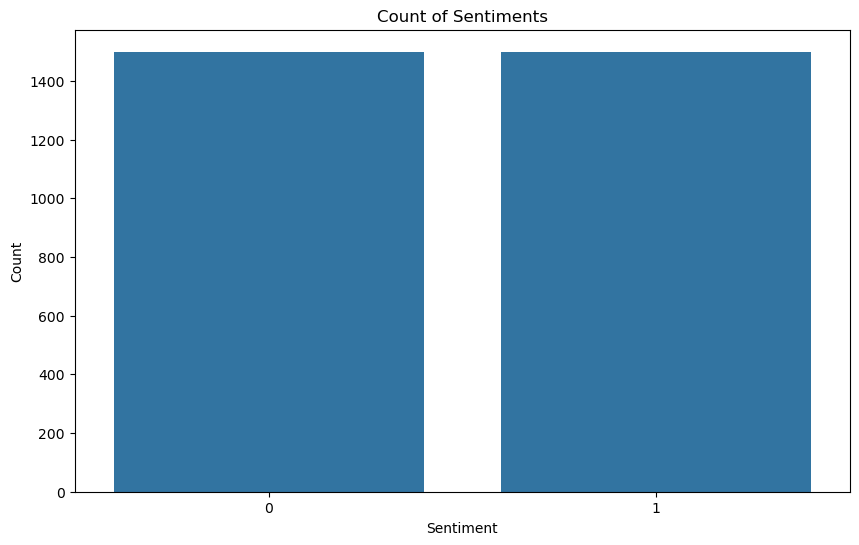

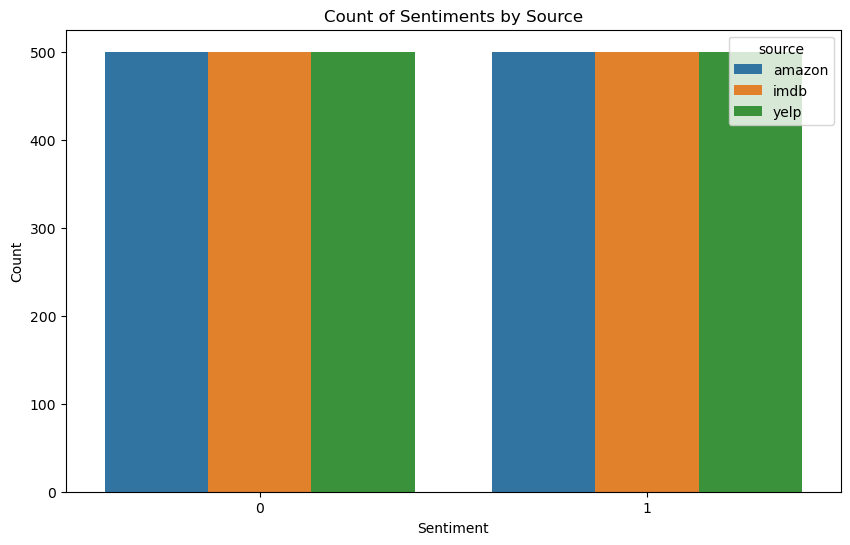

In [3]:
# Check sentiment distribution
sentiment_distribution = df['sentiment'].value_counts(normalize=True)
print("Sentiment distribution:\n", sentiment_distribution)

# Plot sentiment counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Count of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot sentiment counts by source
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='source')
plt.title('Count of Sentiments by Source')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Having performed a cursory examination of the dataset I will next work on specific data preparation steps for the RNN. There are several cleaning steps to be performed for ease of analysis, this will be to make all letters lowercase and removing all punctuation. Making all letters lowercase will remove the chance of letter case becoming an issue when selecting words. Likewise the punctuation of the sentiments is not of importance here and removing it will make the analysis cleaner. It's also important to remove stop words, like conjunctions, word particles and other words that aren't useful for the analysis. This helps to simplify the analysis for better accuracy.

The following cleaning tasks will be performed: 

- covert all letters to lowercase
- seperate all contractions to preserve the meanings
- remove all numbers from the text
- remove special characters and punctuation
- ensure only single spaces

In [4]:
# Convert all letters in the 'reviews' column to lowercase
df['cleaned_review'] = df['reviews'].str.lower()

# Define a dictionary of contractions and their replacements
apos_dict = {
    "'s": " is", "n't": " not", "'m": " am", "'ll": " will", 
    "'d": " would", "'ve": " have", "'re": " are", "o'": "o", "'all": " all"
}

# Function to replace contractions
def replace_contractions(text):
    for key, value in apos_dict.items():
        text = text.replace(key, value)
    return text

# Apply contractions replacement
df['cleaned_review'] = df['cleaned_review'].apply(replace_contractions)

# Remove numbers from the cleaned_review text
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'\d+', '', x))

# Remove special characters and punctuation
df['cleaned_review'] = df['cleaned_review'].str.replace(r"[^\w\s]", ' ', regex=True)

# Replace multiple spaces with a single space
df['cleaned_review'] = df['cleaned_review'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Display cleaned data
print("Cleaned reviews:")
print(df['cleaned_review'].head())

Cleaned reviews:
0    so there is no way for me to plug it in here i...
1                            good case excellent value
2                                great for the jawbone
3    tied to charger for conversations lasting more...
4                                     the mic is great
Name: cleaned_review, dtype: object


### B2. Goals of Tokenization

Tokenization is the process of breaking down a text into smaller units, typically words. Each word or subword is then assigned a unique index, known as `word_index`, which is used by the model during the training process. Tokenization also helps in standardizing the text, ensuring that the text is uniformly represented, which is crucial for consistent and accurate model training. [Keras Tokenizer Tutorial with Examples for Beginners](https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/#google_vignette)

In [5]:
# Tokenize the words
df['tokenized_review'] = df['cleaned_review'].apply(word_tokenize)

After tokenizing the words I will perform further cleaning. 

Lemmatization is the process of reducing words to their root which allows for the combining of words that mean essentially the same thing as well as simplifing the language for the model. 

The process of lemmatizing results in some words becoming single letters which are not useful to the model so I will remove those. 

I will flatten the tokens from the dataset into a single list and then count the unique tokens that remain. By plotting their distribution, I can visually assess the frequency of each token in the dataset. The aim is to filter out low-frequency words that may introduce noise and hinder the model's performance. The goal is to strike a balance by removing infrequent tokens to improve model efficiency while retaining enough meaningful data for the model to learn effectively. This process will hopefully lead to better generalization by reducing overfitting.

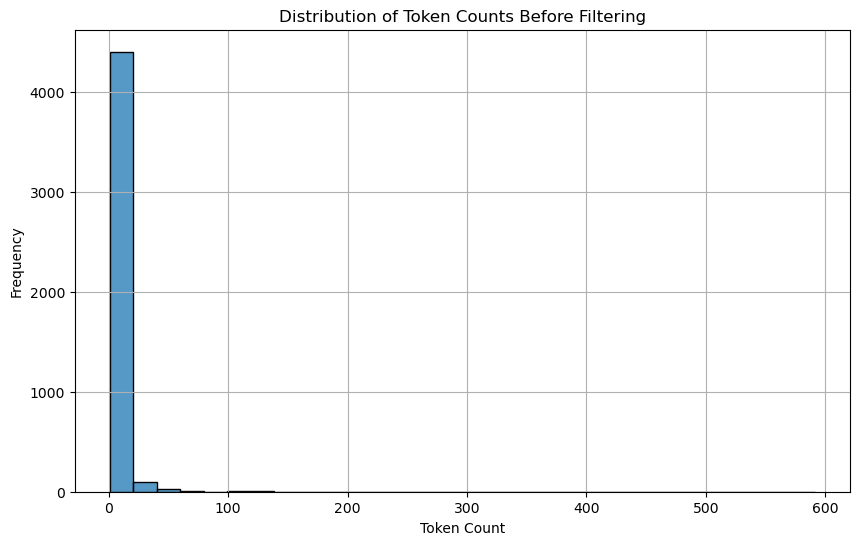

count    4548.000000
mean        4.126429
std        14.086699
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       591.000000
dtype: float64


In [6]:
# Remove stopwords
stop_words = set(stopwords.words('english')) - {'not', 'no'}
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [word for word in x if word not in stop_words])

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Perform lemmatization
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove single letter tokens
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: [word for word in x if len(word) > 1])

# Flatten all tokens into a single list
all_tokens = [word for tokens in df['tokenized_review'] for word in tokens]

# Count token occurrences
token_counts = Counter(all_tokens)

# Create a DataFrame for token counts
token_counts_df = pd.DataFrame(token_counts.items(), columns=['token', 'count'])

# Plot the distribution of token counts before filtering
plt.figure(figsize=(10, 6))
sns.histplot(token_counts_df['count'], bins=30)
plt.title('Distribution of Token Counts Before Filtering')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Inspect token counts
token_counts_series = pd.Series(token_counts)
print(token_counts_series.describe())

There are a significant number of words with fewer than three occurrences in the dataset. These low-frequency words can introduce noise and potentially hinder the model's performance. Given that there are 4,541 unique words in the dataset, I aim to maintain a balance between removing noise and retaining enough informative content. Therefore, I will apply a threshold to keep the top 80% of the most frequently occurring words. 

In [7]:
# Calculate the 80th percentile of token frequencies
percentile_80 = token_counts_series.quantile(0.80)

# Identify tokens that appear more frequently than the 80th percentile count
tokens_above_percentile_80 = {word for word, count in token_counts.items() if count > percentile_80}

# Print the number of tokens above the 80th percentile
print(f"Number of tokens above the 80th percentile: {len(tokens_above_percentile_80)}")

# Print the threshold value for clarity
print(f"Threshold for 80th percentile: {percentile_80}")

Number of tokens above the 80th percentile: 741
Threshold for 80th percentile: 4.0


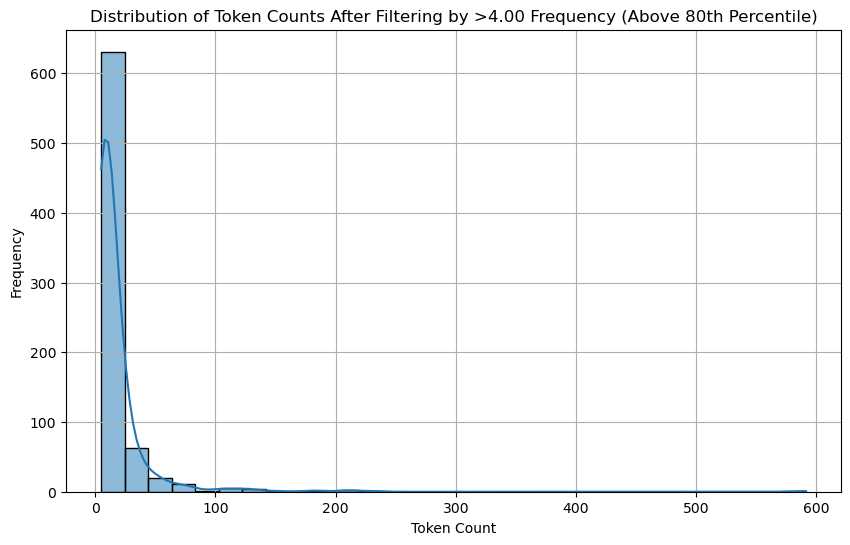

count    741.000000
mean      17.461538
std       31.665271
min        5.000000
25%        6.000000
50%       10.000000
75%       17.000000
max      591.000000
dtype: float64
     token  count
43     not    591
5     good    231
524  movie    212
9    great    210
550   film    187
Threshold for 80th percentile: 4.00


In [8]:
# Filter tokens in the dataset to keep only those in the identified set
df['final_tokens'] = df['tokenized_review'].apply(lambda x: [word for word in x if word in tokens_above_percentile_80])

# Flatten all filtered tokens into a single list for counting
filtered_tokens_threshold = [word for tokens in df['final_tokens'] for word in tokens]

# Count occurrences of each token in the filtered list
filtered_token_counts_threshold = Counter(filtered_tokens_threshold)

# Create a DataFrame from the filtered token counts
filtered_token_counts_df_threshold = pd.DataFrame(filtered_token_counts_threshold.items(), columns=['token', 'count'])

# Plot the distribution of token counts after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_token_counts_df_threshold['count'], bins=30, kde=True)
plt.title(f'Distribution of Token Counts After Filtering by >{percentile_80:.2f} Frequency (Above 80th Percentile)')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Inspect token counts
token_counts_series = pd.Series(filtered_token_counts_threshold)
print(token_counts_series.describe())
print(filtered_token_counts_df_threshold.sort_values(by='count', ascending=False).head())

# Print the threshold value used for clarity
print(f"Threshold for 80th percentile: {percentile_80:.2f}")

In [9]:
# Display the number of unique tokens after filtering
num_unique_tokens = len(set(filtered_tokens_threshold))
print(f"Number of unique tokens after final filtering: {num_unique_tokens}")

# Display a random sample of tokens
sample_size = min(20, len(filtered_token_counts_threshold))
sampled_word_counts = random.sample(filtered_token_counts_threshold.items(), sample_size)
print("Random sample of word counts after final filtering:")
for word, count in sampled_word_counts:
    print(f'Word: {word}, Count: {count}')

Number of unique tokens after final filtering: 741
Random sample of word counts after final filtering:
Word: mobile, Count: 5
Word: free, Count: 9
Word: enjoy, Count: 12
Word: imagination, Count: 5
Word: first, Count: 47
Word: camera, Count: 23
Word: recently, Count: 5
Word: menu, Count: 17
Word: ok, Count: 5
Word: exactly, Count: 6
Word: value, Count: 11
Word: old, Count: 18
Word: horror, Count: 9
Word: incredibly, Count: 5
Word: ended, Count: 5
Word: single, Count: 7
Word: well, Count: 92
Word: ago, Count: 9
Word: brilliant, Count: 7
Word: easy, Count: 22


C:\Users\natal\AppData\Local\Temp\ipykernel_41868\2931026645.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_word_counts = random.sample(filtered_token_counts_threshold.items(), sample_size)


In this analysis, I opted for an 80th percentile threshold to retain the most frequently occurring words, thereby ensuring that the most informative and relevant vocabulary is preserved. This decision aims to balance noise reduction with data retention. By filtering out the words that appear below the 80th percentile of frequency, we reduce noise and computational load, which enhances the efficiency of model training. This approach supports better generalization by focusing on the core features of the text, reducing the risk of overfitting, and maintaining adequate variability in the dataset.

Having removed words I now need to remove any rows that are empty.

In [10]:
# Display the initial number of rows before removing empty ones
print(f"Initial number of rows: {len(df)}")

# Remove rows with empty token lists
df = df[df['final_tokens'].apply(len) > 0]

# Display the number of rows after removing empty ones
print(f"Number of rows after removing empty token lists: {len(df)}")

# Check if there are any empty lists remaining
empty_rows = df[df['final_tokens'].apply(len) == 0]
print(f"Number of empty rows remaining: {len(empty_rows)}")

Initial number of rows: 3000
Number of rows after removing empty token lists: 2949
Number of empty rows remaining: 0


### B3. Padding Process

Padding is a crucial step in natural language processing because all input sequences in the dataset need to have the same length to preserve the shape of tensor dimensions. This is important because neural networks typically expect fixed-size input, especially when using mini-batch training. In our dataset, the review lengths vary between 1 and 19 words, as seen in the code below. Therefore, we need to pad all of the entries so that they are all 16 tokens in length. Padding can occur either before or after the text sequence. The choice depends on the model's requirements and conventions used in the dataset. In this case, we don't have specific model requirements or conventions, so I have decided to pad at the end (post-padding).

Before adding padding, the data needs to be vectorized. This process converts words into numeric sequences, allowing the model to understand and process the text more effectively. The process is often similar to one-hot encoding but typically uses word embeddings or token indices instead, which are more efficient and informative for NLP tasks.

Before vectorizing the data, I will be splitting the data into train, validation, and test sets to ensure that our model is trained and evaluated properly. The code for this process is detailed in part B5 below.

### B4. Categories of sentiment

In this sentiment analysis task, there are two categories of sentiment:

- Positive Review (1): Indicates a favorable sentiment.
- Negative Review (0): Indicates an unfavorable sentiment.

The activation function for the final dense layer of the network I will be using is sigmoid. The sigmoid function outputs a single probability value between 0 and 1, representing the likelihood that the input belongs to the positive class (1). This probability can be interpreted as the model's confidence in predicting a positive sentiment. The sigmoid function is commonly used in binary classification because of how it compressess the input calues to a probability range. 

### B5. Steps to Prepare Data

As seen above, the first step in preparing the data was to import the three datasets and combine them into one DataFrame. After combining the datasets, I proceeded with data cleaning, which involved:

- Identifying and Removing Unusual Characters:This step ensures that any non-standard or irrelevant characters are removed, making the text more uniform for analysis.
- Converting Text to Lowercase: Converting all text to lowercase helps in standardizing the data and avoiding duplicate entries due to case differences (e.g., "Word" vs. "word").
- Removing Punctuation: Punctuation is generally not useful in sentiment analysis and can be removed to simplify the text data.
- Checking for Null and NA Data: Ensuring there are no missing values that could cause issues during model training.
- Stop Words Removal: I removed common stop words from the sentences, as these words generally do not carry significant meaning and can be considered noise in text analysis.
- Tokenization: I converted all words into individual tokens, breaking down the text into meaningful units for analysis.
- Lemmatization: Lemmatization was performed to reduce words to their base or root form, which helps in standardizing words with similar meanings (e.g., "running" to "run"). [Stemming and Lemmatization Explained with Code | Natural Language Processing](https://www.youtube.com/watch?v=jCY0SvsVTzc&t=2s)
- Token Filtering: I filtered the tokens to retain the top 80% most frequent words, as explained above. This step helps reduce noise and computational complexity by focusing on more informative tokens.

> Next, I will perform the following steps:

- Data Splitting: Now that the data is cleaned and transformed as needed, I will split it into three sets: training, validation, and test. The common practice for splitting is to allocate 60-70% of the data for training, 10-20% for validation, and 20-30% for testing. I have chosen to use 60% for training, 20% for validation, and 20% for testing. Additionally, I will maintain a nearly even split of negative and positive reviews for each set to ensure balanced model learning. [How to Split Data into Three Sets (Train, Validation, and Test) and Why?](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c)

- Padding: As explained in part B3, padding ensures that all input sequences have the same length, which is necessary for consistent tensor dimensions. The first step for this will be to calculate the sentence lengths of all three datasets, then apply padding to make all sequences equal in length.

- Vocabulary Size: I will determine the vocabulary size of the training set, which is crucial for setting the input dimensions of the embedding layer in the model.

- Vectorization: As explained in part B3, vectorization involves converting text tokens into numerical representations that the model can process. This step will be applied to all three sets of data to prepare them for model training.

- Conversion to NumPy Arrays: I want to ensure that the training, validation, and test sets are all stored as NumPy arrays, which is the preferred format for input data in most machine learning frameworks, including TensorFlow and Keras.
  
- Save the CSV Files: Finally, I will save the processed datasets (training, validation, and test sets) as CSV files to submit for this project.

In [11]:
# Split the data into train, validation, and test sets
labels = df['sentiment']
X_train_val, X_test, y_train_val, y_test = train_test_split(df['final_tokens'], labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the sizes of the splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check class distribution in the sets
def class_distribution(labels):
    return pd.Series(labels).value_counts(normalize=True)

print("Training set distribution:\n", class_distribution(y_train))
print("Validation set distribution:\n", class_distribution(y_val))
print("Test set distribution:\n", class_distribution(y_test))

Training set size: 1769
Validation set size: 590
Test set size: 590
Training set distribution:
 sentiment
1    0.500848
0    0.499152
Name: proportion, dtype: float64
Validation set distribution:
 sentiment
1    0.501695
0    0.498305
Name: proportion, dtype: float64
Test set distribution:
 sentiment
1    0.501695
0    0.498305
Name: proportion, dtype: float64


In [12]:
# Calculate sequence lengths before padding
def calculate_sequence_lengths(sequences):
    lengths = [len(seq) for seq in sequences]
    return {
        'max_length': max(lengths),
        'min_length': min(lengths),
        'median_length': np.median(lengths)
    }

# Calculate sequence lengths for each set
train_lengths = calculate_sequence_lengths(X_train)
val_lengths = calculate_sequence_lengths(X_val)
test_lengths = calculate_sequence_lengths(X_test)

# Print sequence lengths for each set
print("Training Set Sequence Lengths:")
print(f"Max Length: {train_lengths['max_length']}")
print(f"Min Length: {train_lengths['min_length']}")
print(f"Median Length: {train_lengths['median_length']}")

print("\nValidation Set Sequence Lengths:")
print(f"Max Length: {val_lengths['max_length']}")
print(f"Min Length: {val_lengths['min_length']}")
print(f"Median Length: {val_lengths['median_length']}")

print("\nTest Set Sequence Lengths:")
print(f"Max Length: {test_lengths['max_length']}")
print(f"Min Length: {test_lengths['min_length']}")
print(f"Median Length: {test_lengths['median_length']}")

Training Set Sequence Lengths:
Max Length: 19
Min Length: 1
Median Length: 4.0

Validation Set Sequence Lengths:
Max Length: 17
Min Length: 1
Median Length: 4.0

Test Set Sequence Lengths:
Max Length: 16
Min Length: 1
Median Length: 4.0


In [13]:
# Tokenizer for the training set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulary_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocabulary_size)

Vocabulary size: 739


In [14]:
# Convert text to sequences and pad them
max_length = max(len(x) for x in X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# Print one of the train sentences in full with padding to show that it is padded
sample_index = random.randint(0, len(X_train_seq) - 1)  # Get a random index from the training set
sample_sentence = X_train_seq[sample_index]  # Retrieve the sample sentence
original_sentence = X_train.iloc[sample_index]  # Use .iloc for position-based indexing

# Print the original sentence and the padded version
print("Original Sentence:")
print(" ".join(original_sentence))  # Join tokens to form a sentence
print("\nPadded Sentence:")
print(sample_sentence)
print("\nLength of Padded Sentence:")
print(len(sample_sentence))

Original Sentence:
item not

Padded Sentence:
[216   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]

Length of Padded Sentence:
19


In [15]:
# Convert labels to numpy array
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Export DataFrames to CSV
train_df = pd.DataFrame(X_train_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
train_df['label'] = y_train
train_df.to_csv('train_data.csv', index=False)

val_df = pd.DataFrame(X_val_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
val_df['label'] = y_val
val_df.to_csv('val_data.csv', index=False)

test_df = pd.DataFrame(X_test_seq, columns=[f'Word_{i+1}' for i in range(max_length)])
test_df['label'] = y_test
test_df.to_csv('test_data.csv', index=False)

print("DataFrames have been exported to CSV files.")

DataFrames have been exported to CSV files.


In [16]:
# Ensure X_train, X_val, and X_test are NumPy arrays
X_train = np.array(X_train_seq)
X_val = np.array(X_val_seq)
X_test = np.array(X_test_seq)

# Ensure y_train and y_val are also NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1769, 19)
y_train shape: (1769,)
X_val shape: (590, 19)
y_val shape: (590,)


## Part 3: Network Architecture

### Interlude

I provide here the initial model that I ran, the third model I ran which showed improvement, and the sixth model I ran which got worse as illustration of why I chose the hyperparameters that I did. The explaination for the changes will be below in section C3 and the changes I made are pointed to in the comments of the code. 

> Initial Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 32)            23648     
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 81,949
Trainable params: 81,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
56/56 [=============================

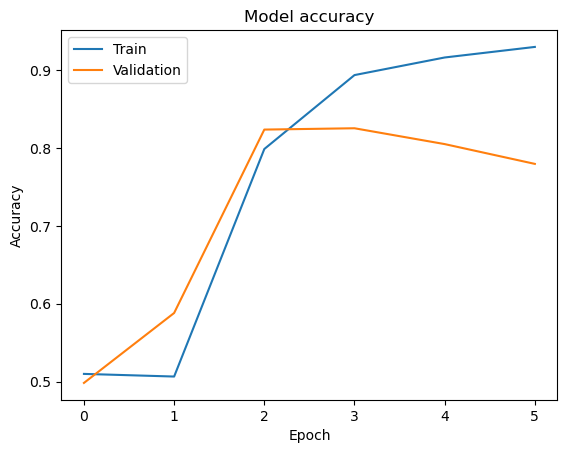

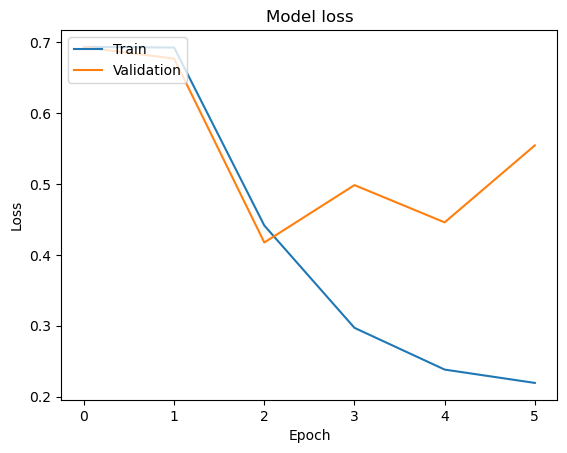

In [17]:
#Set vocabulary size as found above in the training set
vocab_size = 739
#Set the input length as 19, the padded length of all inputs
max_length = 19

#Set up the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add LSTM layer
model.add(LSTM(units=100))

# Add Dropout layer
model.add(Dropout(0.5))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
print(model.summary())

# Compile the model
model.compile(
    optimizer='adam',              
    loss='binary_crossentropy',    
    metrics=['accuracy']           
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=3,                   
    restore_best_weights=True   
)

# Train the model
history = model.fit(
    X_train,                     
    y_train,                     
    epochs=10, 
    batch_size=32,
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model shows signs of overfitting.

> 3rd Model Attempt: Add Bidirectional LSTM layer with L2 regularization

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 32)            23648     
                                                                 
 bidirectional (Bidirectiona  (None, 200)              106400    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                10050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 140,149
Trainable params: 140,149
Non-trainable params: 0
________________________________________________

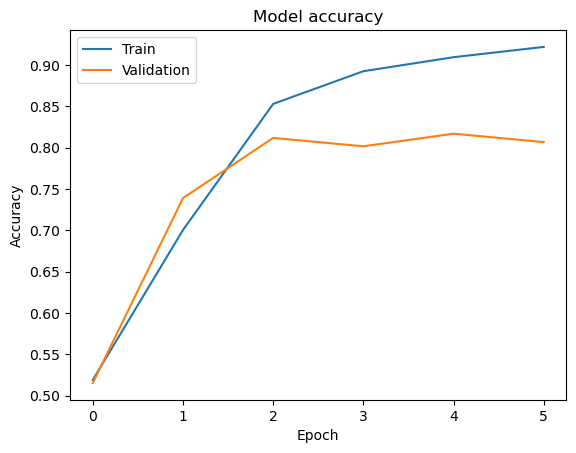

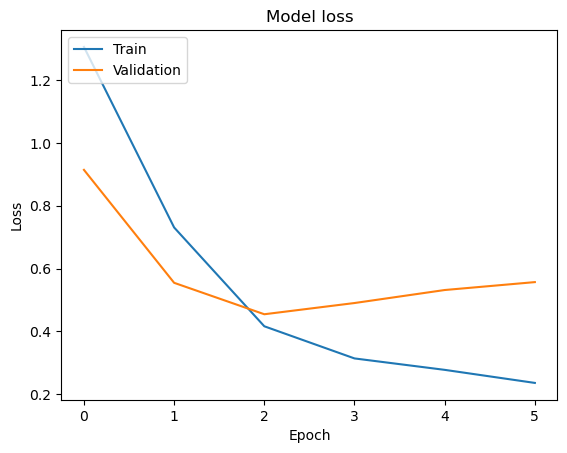

In [18]:
#Set vocabulary size as found above in the training set
vocab_size = 739
#Set the input length as 19, the padded length of all inputs
max_length = 19

# Initialize the model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add a Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=100, kernel_regularizer=l2(0.01))))

# Add a Dropout layer
model.add(Dropout(0.5))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
print(model.summary())

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=3,                   
    restore_best_weights=True   
)

# Train the model
history = model.fit(
    X_train,                     
    y_train,                     
    epochs=10, 
    batch_size=32,
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Better but could use improvement. 

> 6th Model Attempt: Kept the Bidirectional LSTM layer and L2 regularization. Increased the dropout layer from 0.5 > 0.6. Increase patience from 3 > 5. Increase epochs from 10 > 15. 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 32)            23648     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              106400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                10050     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 140,149
Trainable params: 140,149
Non-trainable params: 0
________________________________________________

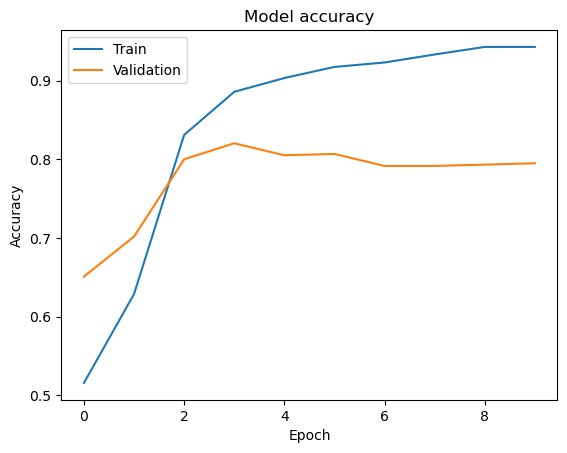

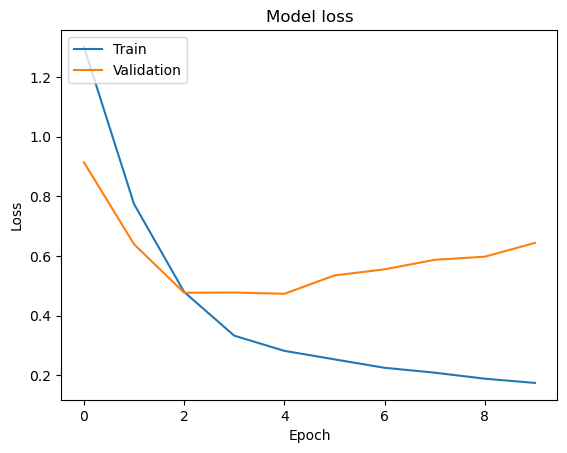

In [19]:
#Set vocabulary size as found above in the training set
vocab_size = 739
#Set the input length as 19, the padded length of all inputs
max_length = 19

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add a Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=100, kernel_regularizer=l2(0.01))))

# increase Dropout layer
model.add(Dropout(0.6))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
print(model.summary())

# Compile the model
model.compile(
    optimizer='adam',              
    loss='binary_crossentropy',    
    metrics=['accuracy']           
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True   
)

# Train the model
history = model.fit(
    X_train,                     
    y_train,                     
    epochs=15, 
    batch_size=32,
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### C1. Output of Model Summary

In [20]:
#Set vocabulary size as found above in the training set
vocab_size = 739
#Set the input length as 19, the padded length of all inputs
max_length = 19

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))

# Add a Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=50, kernel_regularizer=l2(0.03))))

# increase Dropout layer
model.add(Dropout(0.7))

# Add Dense layer with ReLU activation
model.add(Dense(50, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 32)            23648     
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              33200     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 61,949
Trainable params: 61,949
Non-trainable params: 0
__________________________________________________

### C2. Layers and Parameters

In [21]:
# Compile the model
model.compile(
    optimizer='adam',              
    loss='binary_crossentropy',    
    metrics=['accuracy']           
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True   
)

# Train the model
history = model.fit(
    X_train,                     
    y_train,                     
    epochs=15, 
    batch_size=62,
    validation_data=(X_val, y_val),  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
29/29 [==============================] - 6s 60ms/step - loss: 3.2435 - accuracy: 0.5116 - val_loss: 2.5372 - val_accuracy: 0.6475
Epoch 2/15
29/29 [==============================] - 1s 25ms/step - loss: 2.0846 - accuracy: 0.5579 - val_loss: 1.6690 - val_accuracy: 0.5966
Epoch 3/15
29/29 [==============================] - 1s 25ms/step - loss: 1.4115 - accuracy: 0.6427 - val_loss: 1.1740 - val_accuracy: 0.6593
Epoch 4/15
29/29 [==============================] - 1s 25ms/step - loss: 1.0122 - accuracy: 0.7021 - val_loss: 0.8682 - val_accuracy: 0.7254
Epoch 5/15
29/29 [==============================] - 1s 25ms/step - loss: 0.6907 - accuracy: 0.8225 - val_loss: 0.6292 - val_accuracy: 0.7949
Epoch 6/15
29/29 [==============================] - 1s 25ms/step - loss: 0.4797 - accuracy: 0.8660 - val_loss: 0.5198 - val_accuracy: 0.8119
Epoch 7/15
29/29 [==============================] - 1s 25ms/step - loss: 0.3721 - accuracy: 0.8999 - val_loss: 0.5090 - val_accuracy: 0.8203
Epoch 8/15
29

This model has 5 layers: 

1. Embedding Layer: The purpose of this layer is to transform integer-encoded words into dense vectors of fixed size, making it easier for the model to understand the textual data. The configuration of this layer includes

        - the input dimension (`input_dim`) which is the vocabulary size of 739.
        - the output dimension (`output_dim`) 32 which is the embedding size for each word.
        - the input length, which is 19, the length of all sequences after padding.

- The Parameters of this layer are found by multiplying the input dimension by the output dimension, 739 and 32 respectfully, which is 23.

[What is Dimensionality in Word Embeddings](https://stackoverflow.com/questions/45394949/what-is-dimensionality-in-word-embeddings)

2. Bidirectional LSTM Layer: This layer captures the dependencies both forwards and backwards, giving the model an understanding of context. The configuration of this layer includes

        - the number of LSTM units, in this model that number is 50.
        - The L2 Regularization with a penalty of 0.03 to help prevent overfitting.

- The Parameters of this layer are a little more complicated. Each LSTM unit has four sub-components and each of these has weights connected to the inputs, and since this is bidirectional that means everything is doubled, so the equation for the paramenters in this layer would be $4 x (50 x (50 + 32) + 50) x 2 = 33,200$.

3. Dropout Layer: The dropout layer regularizes the model by randomly setting a fraction of input units to 0 during training which prevents overfitting. In this case that fraction is 70%.

       - The only configuration for this is the rate of 0.7

- There are no additional parameters in this layer.

4. Dense Layer: This layer is a fully connected layer that allows for learning complex patterns. The configuration is

        - The units which are 50
        - The activation type which is ReLU (rectified linear unit) which helps introduce non-linearity.

- The parameters for this layer connect the LSTM layer outputs to 50 neurons. So the equation here is $(100+1)x50=5050$

5. Output Dense Layer: This layer produces the final binary classification output. The configuration is

        - Units: 1
        - The activation, Sigmoid, which outputs a probability between 0 and 1 for binary classification.

- The parameters for this layer connect the 50 neurons from the previous layer to a single output neuron. Therefore the equation is $(50+1)x1=51$

Therefore in total the Parameters of the model are:

    - Embedding Layer: 23,648
    - Bidirectional LSTM Layer: 33,200
    - Dropout Layer: 0
    - First Dense Layer: 5.050
    - Output Dense Layer: 51
    
$23,648+33,200+5,050+51=61,949$

The parameters are the weights and biases that the model learns during the training to map inputs to outputs effectively. 

## C3. Justify Hyperparameters

The hyperparameters collectively aim to build a robust model that generalizes well to unseen data while being computationally efficient and easy to train. Throughout the process of finding the right model I explored many different options for these hyperparameters until I found the combinations that was able to best optimize the model. The hyperparameters are:

1. Activation Functions:
   - Sigmoid in the Output Layer: Sigmoid was chosed for the output layer because it works best for binary classification tasks. The output is a probability value between 0 and 1 which the model to interprets as the probability of the input belonging to the positive class.
    - ReLU in the Dense Layer: ReLU is the most popular choice for hidden layers because it introduces non-linearity while avoiding issues like vanishing gradients. ReLU helps models learn complex patterns efficiently, which leads to faster convergence.
                                
3. Number of Nodes Per Layer:
   - Embedding Layer: The embedding layer has 32 nodes, this choice was made to balance computational efficiency and expressive power. This amount is sufficient to capture meaningful semantic information about the words without excessive computation.
    - LSTM Layer: This layer had 50 units. This hyperparameter was one of the ones that I changed as I fine tuned the model. I started with 100 units but found that when I decreased to 50 the model performed better in the balance between accuracy and overfitting. 50 units is a common choice because it allows the model to learn representations of the sequence effectively, considering both past and future context.
    - Dense Layer: The dense layer had 50 nodes. The nodes in the dense layer help create a bridge between the sequence representation of the LSTM and the single output node. Fifty nodes provided sufficient capacity to capture intermediate features that are important for classification without being so large that the model bogged down.

4. Loss Function: I used Binary crossentropy as the loss function because it is suitable for a binary classification task. It quantifies the difference between predicted probabilities and the actual class labels. Binary crossentropy also penalizes incorrect predictions, encouraging the model to learn a probability distribution that closely matches the target distribution.

5. Optimizer: The Adam optimizer is widely used because of it's adaptibility in learning rate capabilities. It's a robust optimizer for many different data types and can achieve faster convergence and better performance across different tasks.

6. Stopping Criteria: Early stopping helps prevent overfitting by monitoring the validation loss and stopping the training when there are no improvements being observed over the specified number of epochs. This is another hyperparameter that I adjusted as I fine tuned my model, choosing a higher patience to give the model more time to try and even out. In the end I decided on a patience of 5 which allowed the model some flexibility to find optimization.

7. Evaluation Metric: I chose Accuracy as the evalution metric as this is the appropriate metric for binary classification tasks especially when the classes are balanced. Accuracy gives a straightforward measure of the model's performance by calculating the porportion of correctly predicted instances.

### Part 4: Model Evaluation

### D1. Stopping Criteria Impact

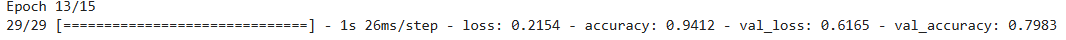

- Prevention of Overfitting:
  Early stopping is a regularization technique that helps prevent overfitting by halting training when the model's performance on the validation set stops improving. In the provided screenshot, training stops at epoch 13, indicating that further training would likely lead to overfitting, as evidenced by the validation loss starting to stabilize or increase after this point.
In the 13th epoch, the training accuracy is 94.12%, while the validation accuracy is 79.83%. This difference shows a slight overfitting trend, but early stopping mitigates further divergence.

- Efficient Resource Utilization:
    By stopping the training process early, resources such as time and computational power are conserved. This is particularly important in large-scale models or datasets where training can be resource-intensive. Epoch 13/15 signifies that training stopped at epoch 13 out of a possible 15, demonstrating efficient use of available resources by avoiding unnecessary additional training epochs.
  
- Determining the Optimal Number of Epochs:
    The number of epochs in training refers to the complete passes through the entire training dataset. Without early stopping, one might arbitrarily choose a high number of epochs, risking overfitting. Early stopping helps determine the optimal number of epochs by monitoring the validation loss or accuracy and halting training when improvements cease. This ensures that the model does not waste time learning noise.
  
- Improved Generalization:
    By stopping training at the point where the validation accuracy begins to plateau, the model can better generalize to unseen data. This prevents the model from memorizing the training data, which is crucial for robust model performance on new, unseen data.
  
- Balancing Training and Validation Metrics:
    Early stopping maintains a balance between training and validation metrics. In this example, stopping at epoch 13 avoids a scenario where the training accuracy would further increase at the cost of validation accuracy, leading to a wide generalization gap.

### D2. Fitness of Model and Overfitting

1. Training and Validation Performance:

> Training Accuracy: 94.12%
  Validation Accuracy: 79.83%
  Training Loss: 0.2154
  Validation Loss: 0.6165

These metrics indicate that the model performs well on the training data, achieving high accuracy and low loss. However, the gap between training and validation performance suggests some overfitting, as the model's ability to generalize to new data is less optimal. The steps I took to decrease the overfitting are below, but this was the closest I was able to make the gap.

2. Generalization Ability:
The model has a good capacity to learn from the training data, but there is room for improvement in its generalization ability, as shown by the validation performance metrics.
The model's architecture and hyperparameters have been carefully adjusted to mitigate overfitting while maintaining predictive power.

3. Early Stopping:
Early stopping was implemented as a means of preventing overfitting by monitoring the validation loss. Training was halted when the validation loss stopped improving, thus ensuring the model does not continue learning noise from the training data.
The model was stopped at epoch 11 out of a possible 15, demonstrating an optimal balance between training and validation performance.

**Actions Taken to Address Overfitting**
1. Bidirectional LSTM:
This architecture allows the model to capture dependencies in both forward and backward directions, improving the model's understanding of context within sequences.

2. L2 Regularization:
The kernel regularization parameter was increased from 0.01 to 0.03, which adds a penalty to large weights, discouraging complex models that can overfit to the training data.

These adjustments help the model focus on essential features by penalizing overly complex solutions, thus reducing overfitting.

3. Reduced LSTM Units:
Reducing the units in the LSTM layer from 100 to 50 decreases the model's complexity, limiting its capacity to memorize training data and encouraging it to generalize better to unseen data.

4. Increased Dropout:
Dropout was increased from 0.05 to 0.07, which randomly drops a fraction of the layer's units during training, effectively preventing the network from relying too heavily on any single neuron. This acts as a form of regularization, helping the model to generalize better.

5. Patience Increase:
Increasing the patience of early stopping from 3 to 5 allows the model more opportunities to improve its performance during training, especially in situations where progress might temporarily stagnate before improving further. This is a way to avoid prematurely halting training while still guarding against overfitting.

6. Increased Epochs:
From 10 to 15, providing the model with more time to learn patterns in the data. The use of early stopping ensures that this increase does not lead to overfitting.

7. Changed Batch Size:
From 32 to 62, which can have multiple effects, including reducing noise in the updates to model weights during training. A larger batch size may also lead to more stable convergence.

Below is the result of the model on the test data to evaluate the fitness of the model. 

In [22]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

19/19 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8000
Test Loss: 0.5268449187278748
Test Accuracy: 0.800000011920929


**Model Evaluation on Test Data**

*Test Loss: 0.5268*

The test loss measures the model's error on the test set. A lower loss generally indicates better model performance. In this case, a test loss of 0.5268 suggests that while the model makes some errors, its performance is likely consistent with the training and validation phases.

*Test Accuracy: 80%*

The test accuracy indicates that the model correctly predicts the sentiment of approximately 80% of the test samples. This is a reasonable performance, especially because it aligns closely to the validation accuracy, which suggests that the model is generalizing well to unseen data.

The validation accuracy was slightly lower than the test accuracy, 79.83% vs 80% (with rounding they are both 80% so the difference is incredibly small), this does suggest that the model does some overfitting on the training data but it is still got the ability to generalize to new, unseen data fairly accurately. 

The validation loss, 0.62, is very close to the test loss of 0.52. The validation is actually slightly higher than the test loss which is a good indication that the overfitting is only minor. With a test accuracy close to the training and validation accuracies, this model is generalizing well, thanks to the tuning of the hyperparameters I did to address the overfitting in the earlier models. Given the regularization and dropout measures, along with the early stopping mechanism, the model has effectively mitigated overfitting to some extent. 

### D3. Visualizations and Evaluation Metric

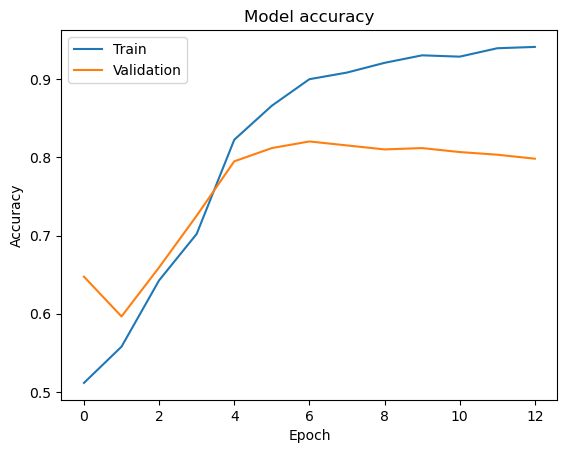

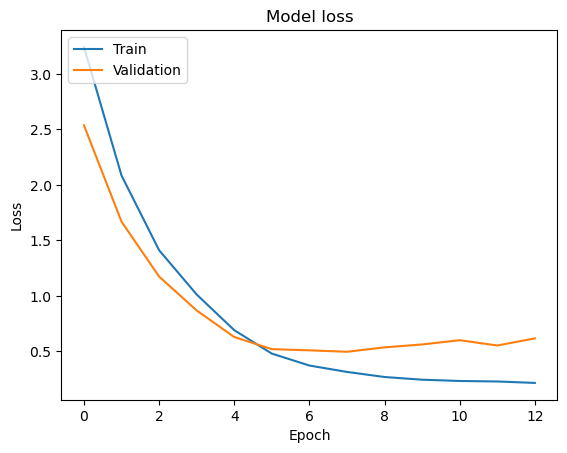

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

19/19 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8000
Test Loss: 0.5268
Test Accuracy: 0.8000
19/19 [==============================] - 1s 6ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80       294
    Positive       0.79      0.82      0.80       296

    accuracy                           0.80       590
   macro avg       0.80      0.80      0.80       590
weighted avg       0.80      0.80      0.80       590



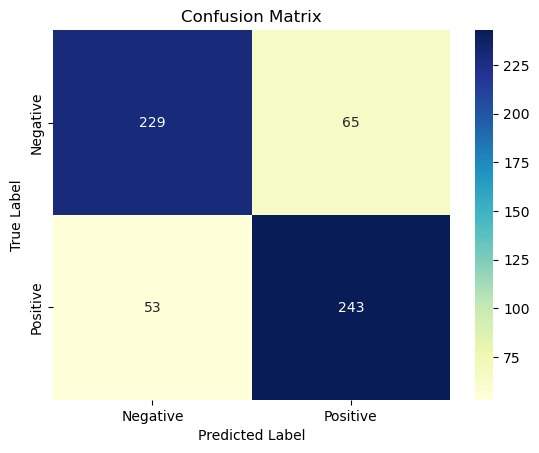

In [24]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and then convert them to binary outcomes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### D4. Predictive Accuracy

**Overview of Results:**
*Test Accuracy:* The model achieved an accuracy of 80% on the test set. This indicates that approximately 80% of the test samples were correctly classified.

*Test Loss:* The test loss is 0.5268, which reflects the error between the predicted outputs and the true labels. A lower loss indicates better performance, but it should be interpreted in conjunction with accuracy and other metrics.

**Confusion Matrix Analysis:**
The confusion matrix provides insights into the performance of the classification model by showing the number of correct and incorrect predictions broken down by each class:

> - True Negatives (TN): 229 (Negative reviews correctly classified)
> - False Positives (FP): 65 (Negative reviews incorrectly classified as Positive)
> - False Negatives (FN): 53 (Positive reviews incorrectly classified as Negative)
> - True Positives (TP): 243 (Positive reviews correctly classified)

**Precision, Recall, and F1-Score:**
*Precision:* Precision measures the accuracy of positive predictions and is calculated as:

$$
Precision=\frac{TP}{TP+FP}
$$
​
*Negative class:* 81% of the reviews predicted as Negative were actually Negative
*Positive class:* 79% of the reviews predicted as Positive were actually Positive

*Recall (Sensitivity):* Recall measures the ability of the model to correctly identify positive instances and is calculated as:

$$
Recall=\frac{TP}{TP+FN}
$$
 
*Negative class:* 78% of actual Negative reviews were correctly classified
*Positive class:* 82% of actual Positive reviews were correctly classified

*F1-Score:* The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics:

$$
F1-Score=2x\frac{PrecisionxRecall}{Precision+Recall}
$$
​
*Negative class:* 0.80
*Positive class:* 0.80

**Macro and Weighted Averages:**
*Macro Avg:* The unweighted average of precision, recall, and F1-score across all classes, for assessing the model's overall balance.
*Weighted Avg:* Takes class imbalance into account by weighing each class's score by the number of instances in that class.

**Interpretation of Results:**
The model is slightly better at identifying positive reviews, as indicated by a higher recall for the positive class (0.82) compared to the negative class (0.78). This suggests that the model is more inclined to predict a review as positive when uncertain, which is reflected in the higher false positive rate for negative reviews. The relatively balanced precision and recall for both classes indicate that the model does not heavily favor one class over the other, which is great for sentiment analysis tasks where both positive and negative reviews are equally important. Overall, the model demonstrates a good balance between precision and recall for both classes, with a test accuracy of 80%. The confusion matrix reveals a slight bias toward predicting positive reviews, which could be fine-tuned with further model adjustments or hyperparameter tuning. The evaluation metrics suggest that the model is robust, with a strong ability to generalize across the test dataset. However, further improvements could be made by experimenting with additional features or adjusting model complexity to enhance predictive accuracy.

## Part 5: Summary and Recommendations

### E. Code for Trained Netword

In [25]:
# Save model
model.save('sentiment_analysis_model.h5')

### F. Functionality of Neural Network

**Network Architecture and Functionality:**
- The Embedding Layer transforms input words into dense vectors of fixed size (32 in this case), capturing semantic relationships between words.
This allows the model to learn word embeddings during training, improving its ability to understand word context and similarity.

- The Bidirectional LSTM Layer processes input sequences in both forward and backward directions, allowing the model to capture dependencies from both past and future words in a sequence. This enhances the model's ability to understand contextual information, which is crucial for sentiment analysis, where word order and context significantly affect meaning. This layer also provides information retention which, again, allows the model to leverage the entire context of each sentence, capturing nuances that influence sentiment classification.

- L2 Regularization adds a penalty term to the loss function to prevent overfitting by discouraging complex models. This helps in reducing overfitting by constraining the model's weights, making it more robust to unseen data.
  
- The Dropout Layer randomly drops units during training to prevent overfitting. It introduces noise during training, which encourages the model to learn more robust features, preventing it from relying too heavily on any one feature. In combination with the L2 regularization, dropout helps control overfitting by ensuring that the model does not become too complex. In this model the balance between the training and validation accuracy suggests that the model generalizes well.
  
- Dense Layers perform classification using the features learned from previous layers. The first dense layer uses ReLU activation, while the final dense layer uses sigmoid activation. The ReLU activation helps in learning complex patterns, while the sigmoid function in the output layer is well-suited for binary classification tasks, providing a probability score for the positive class.

- The model has 61,949 trainable parameters, complex enough to capture patterns without being excessively large. 

- The use of Adam as an optimizer balances the speed of convergence and stability, ensuring efficient training while handling noisy gradients effectively.

This network effectively balances complexity and regularization to achieve robust performance on the sentiment analysis task. The choice of a bidirectional LSTM is particularly effective, as it helps the model understand sentence semantics from both directions. Additionally, the dropout and L2 regularization layers are critical in ensuring the model does not overfit, maintaining its ability to generalize across the test data.

### G. Course of Action

This model demonstrates strong performance with a balanced trade-off between precision and recall. With further fine-tuning and potential architectural improvements, the model's predictive accuracy could be enhanced and working on that would help to give clearer insights to companies that are interested in the sentiment analysis for data driven decisions. Overall this model satisfies the research question, can Neural Networks and Natural Language Processing effectively analyze customer sentiment to help companies take actions to improve customer satisfaction? Yes, they can be incredibly useful in categorizing user feedback and with further improvement this model could be of use to the stakeholders of these companies to improve customer satisfaction.

## Sources

DataCamp Courses [Introduction to Deep Learning in Python](https://app.datacamp.com/learn/courses/introduction-to-deep-learning-in-python), [Introduction to TensorFlow in Python](https://app.datacamp.com/learn/courses/introduction-to-tensorflow-in-python), and [Building Chatbots in Python](https://app.datacamp.com/learn/courses/building-chatbots-in-python) were used to help develop the code used in this project.

Course instructor videos by Dr. Elleh: D213 T2 Data Preprocessing in Python and D213 T2 Building NN Model in Python as well as by Dr. Sewell: D213 Webinar 3, D213 Webinar 4 Video, D213 Webinar 5 SA, D213 Webinar 6 SA and the accompaning powerpoints were used for developing the code and understanding some of the concepts. 

Dr. Elleh's D213 Task 2 Cohort Webinar Powerpoint was also used. 

Along with the DataCamp courses and course instructor resources the following articles and videos were essential for the completion of this project:

[How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

[Understanding Embedding Layer in Keras](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce)

[Gradient Descent, How Neural Networks Learn|Chapter 2, Deep Learning](https://www.youtube.com/watch?v=IHZwWFHWa-w)

[Python - Efficient Text Data Cleaning](https://www.geeksforgeeks.org/python-efficient-text-data-cleaning/)

[Sentiment Analysis with an Recurrent Neural Networks (RNN)](https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/)

[Cleaning & Preprocessing Text Data for Sentiment Analysis](https://towardsdatascience.com/cleaning-preprocessing-text-data-for-sentiment-analysis-382a41f150d6)

[An Easy Tutorial about Sentiment Analysis with Deep Learning and Keras](https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91)

[TensorFlow - Text Classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

[Sentiment Analysis using Recurrent Neural Network (RNN), Long Short Term Memory (LSTM) and Convolutional Neural Network(CNN) with Keras.](https://medium.com/@muhammadluay45/sentiment-analysis-using-recurrent-neural-network-rnn-long-short-term-memory-lstm-and-38d6e670173f)

[A Beginner's Guide on Sentiment Analysis with RNN](https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e)

[Sentiment Analysis using Neural Network and LSTM](https://www.researchgate.net/publication/349628900_Sentiment_Analysis_using_Neural_Network_and_LSTM)

[Recurrent Neural Networks - Ep. 9 (Deep Learning Simplified)](https://www.youtube.com/watch?v=_aCuOwF1ZjU)

[Deep Learning with Tensorflow - The Recurrent Neural Network Model](https://www.youtube.com/watch?v=C0xoB8L8ms0)

[Keras Tokenizer Tutorial with Examples for Beginners](https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/#google_vignette)

[Stemming and Lemmatization Explained with Code | Natural Language Processing](https://www.youtube.com/watch?v=jCY0SvsVTzc&t=2s)

[How to Split Data into Three Sets (Train, Validation, and Test) and Why?](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c)

[What is Dimensionality in Word Embeddings](https://stackoverflow.com/questions/45394949/what-is-dimensionality-in-word-embeddings)